<a href="https://colab.research.google.com/github/Fuenfgeld/DMA2023TeamB/blob/main/codes/ANTICOVIS_SQL_Quelldatenbank_Erstellung.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Erstellung der SQL-Quelldatenbank des ANTICOVIS-Projekts**



### Einleitung


---


Dieses Colab-Books soll der Erstellung einer Datenbank dienen, in die die Daten des Covid19 Datensets geladen werden. Die Datenbank soll dann als Grundlage für weitere Verarbeitungen und Analysen im Rahmen des Projekts dienen.

Quelldatenset: Synthea Covid19 https://github.com/Fuenfgeld/DMA2023TeamB/tree/main/CSV_Data

Primär- und Fremdschlüsselbedingungen werden entnommen aus dem Synthea Repositorium: https://github.com/synthetichealth/synthea/wiki/CSV-File-Data-Dictionary


# Benötigte Libraries laden

In [1]:
from google.colab import drive
import pandas as pd
from functools import reduce
import sqlite3
from sqlite3 import Error
import csv

# Mounten und Pfadangaben

Mounten des Google Drives
Festlegen von Pfadangaben zu Quelldaten und zur Datenbank, die später im Code benötigt werden.

Die Covid19-CSV-Dateien sind zudem separat im ANTICOVIS-Repositorium hinterlegt: https://github.com/Fuenfgeld/DMA2023TeamB/tree/main/CSV_Data

In [2]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [3]:
# Datenbankordner auf Shareddrive checken
!ls "/content/drive/Shareddrives/DMA_2023_D/DMA2023TeamB/Quelldatenbank"

In [4]:
# Quelldatenordner checken
!ls "/content/drive/Shareddrives/DMA_2023_D/DMA2023TeamB/Quelldaten"

allergy  breast_cancer	    covid19	lung_cancer
asthma	 colorectal_cancer  dermatitis	metabolic_syndrome_disease


In [5]:
# Patient:innentyp festlegen (beim ANTICOVIS-Projekt interessiert nur die Erkrankung Covid19)
patient_type = "covid19"

In [6]:
# Datenbankpfad setzen
DB_FILE_PATH = "/content/drive/Shareddrives/DMA_2023_D/DMA2023TeamB/Quelldatenbank/source_covid19_ANTIVOVIS_db.db"

# Pfad zu CSV Dateien setzen
csv_path = "/content/drive/Shareddrives/DMA_2023_D/DMA2023TeamB/Quelldaten/covid19/"

DB_FILE_PATH, csv_path

('/content/drive/Shareddrives/DMA_2023_D/DMA2023TeamB/Quelldatenbank/source_covid19_ANTIVOVIS_db.db',
 '/content/drive/Shareddrives/DMA_2023_D/DMA2023TeamB/Quelldaten/covid19/')

#Versionen verwendeter Python-, Pandas- und SQlite3-Pakete abfragen

In [7]:

# Python-Version
print("Python-Version:")
!python --version

# Pandas-Version
print("\n" + "Pandas-Version:")
print(pd.__version__)

# sqlite3-Version
print("\n" + "sqlite3-Version:")
sqlite3.sqlite_version

Python-Version:
Python 3.8.10

Pandas-Version:
1.3.5

sqlite3-Version:


'3.31.1'

# ER-Modell aller Quelldaten

Die Beziehungen der Tabellen der gesamten Quelldaten von Covid19 untereinander kann folgender Illustration des ER-Modells entnommen werden.
Im untenstehenden ER-Modell ist die Datentyp-Beschreibung von Synthea dargestellt.

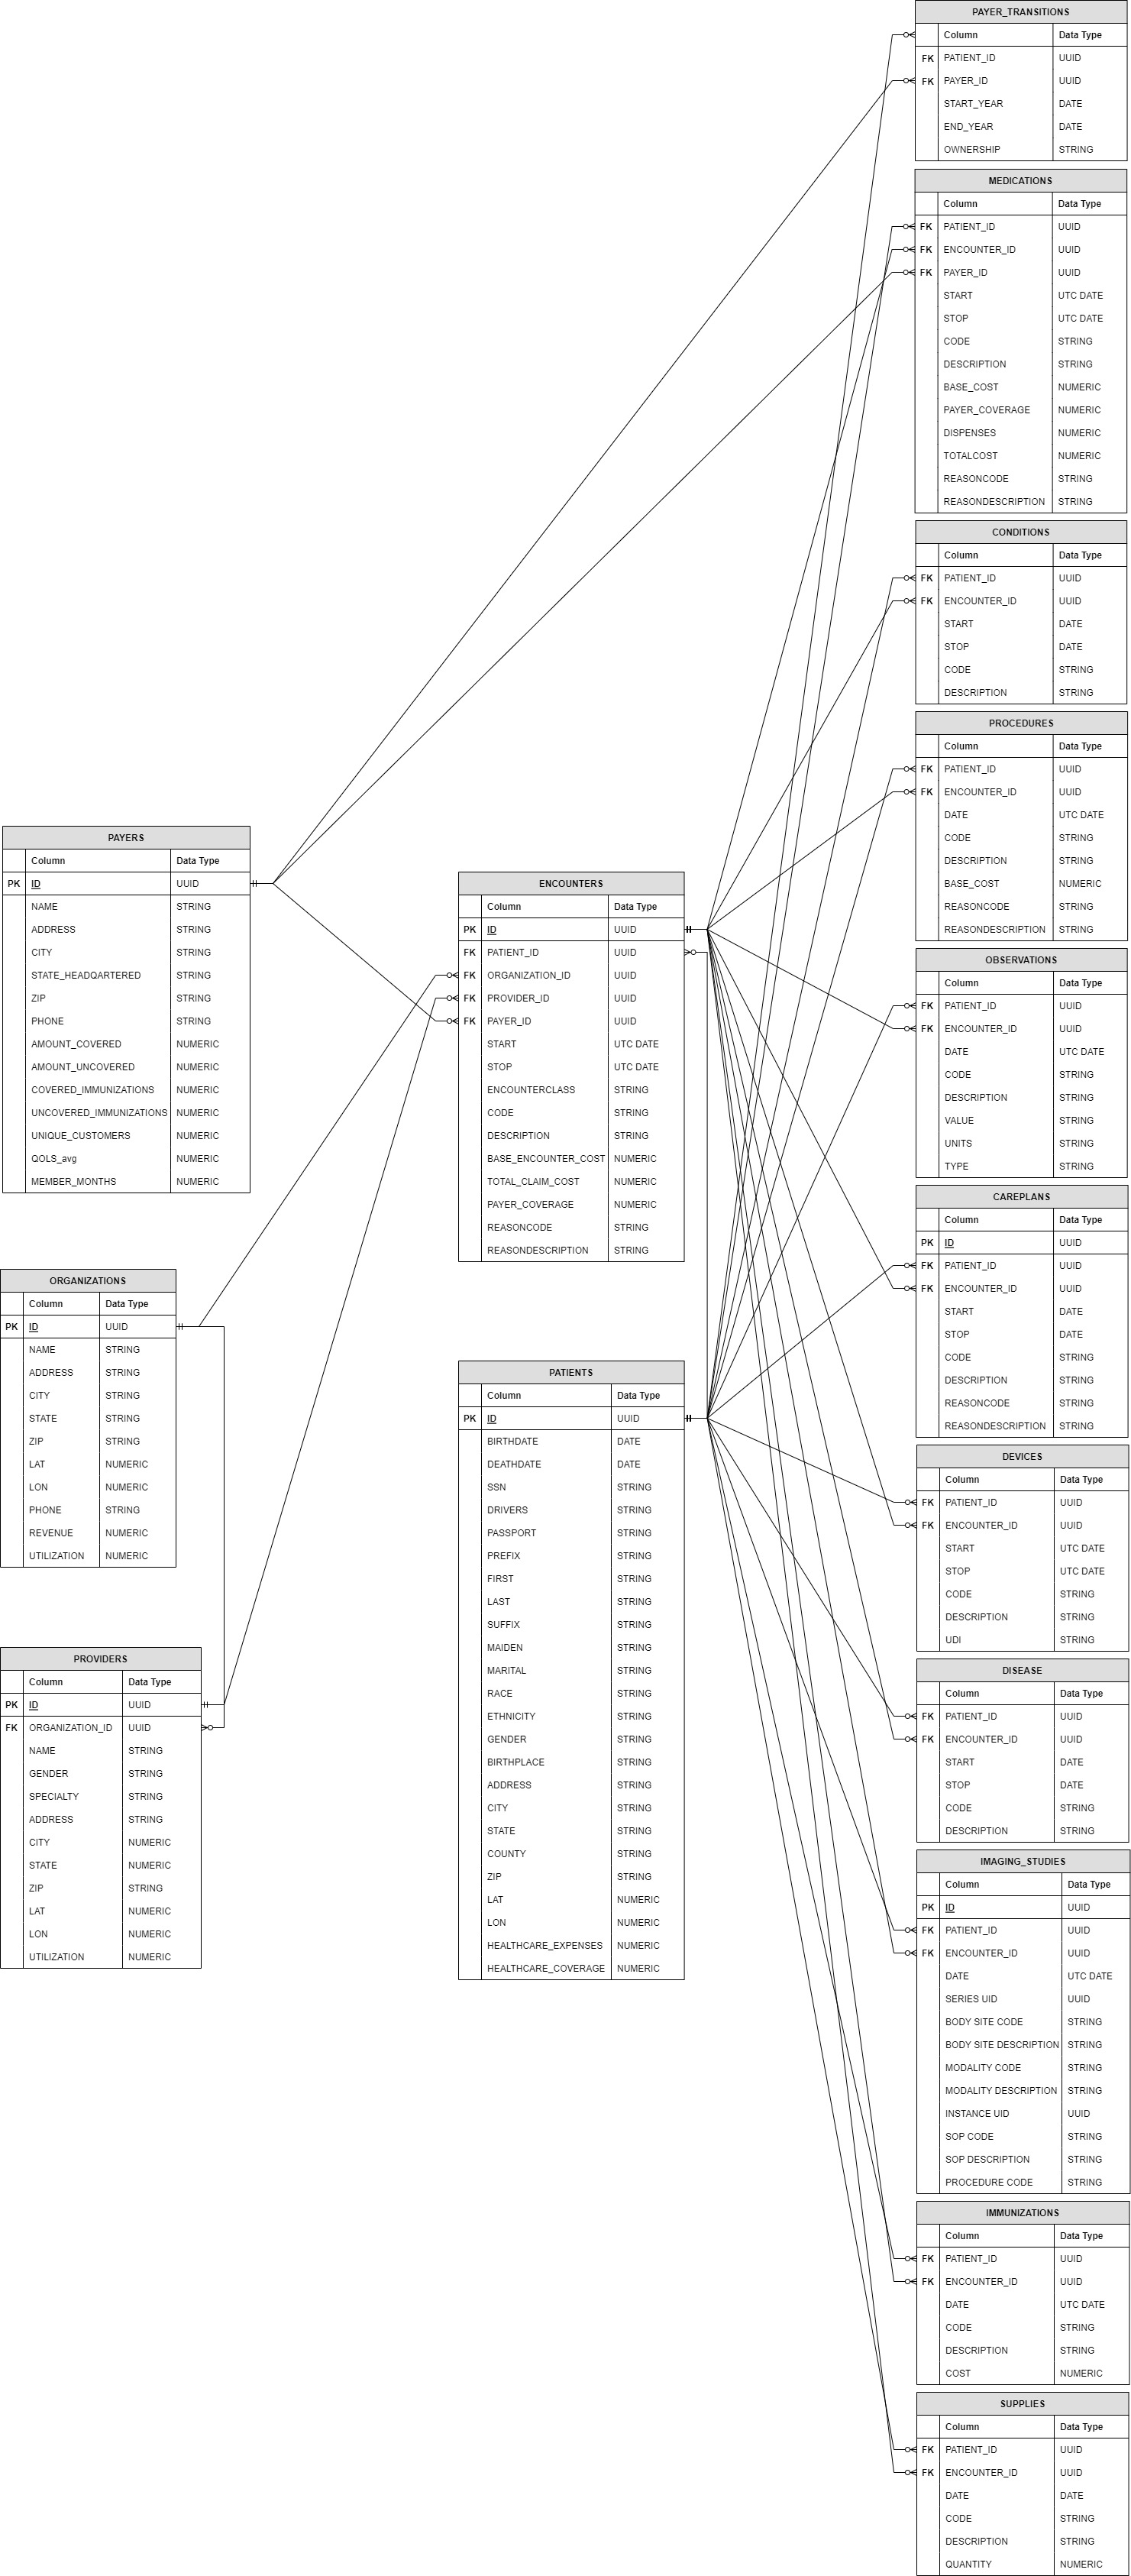

#SQL Tabellen anlegen

Es wird ein Dictionary angelegt, in welchem alle Tabellen des Covid19 Datensets später hereingeladen werden sollen. Die Tabellen werden mittels Create Table-Anweisungen erstellt.
Die Tabellenkonfiguration (Spalten, Datentypen) sowie Schlüsselbedingungen basieren, wie oben genannt, auf der Synthea-eigenen Datenset-Dokumentation (https://github.com/synthetichealth/synthea/wiki/CSV-File-Data-Dictionary).

Nach Sichten der Quelldaten werden nur solche Tabellen erzeugt, die für die weitere Bearbeitung und Analyse des Projekts benötigt werden.
Somit erfolgt keine Create Table-Anweisung für Tabellen, die im Covid19-Datensatz leer sind (disease, imaging_studies) oder nicht erforderlich sind (careplans, observations, payer_transitions, payers, providers, supplies).

#ER-Modell der Quelldaten für das ANTICOVIS-Projekt

In [8]:
# dictionary key: name of table, values: sql query to create table
sql_table = {}

In [9]:
# SQL-Anweisung zur Erstellung der Tabelle "conditions"
sql_table["conditions"] = """CREATE TABLE IF NOT EXISTS conditions (
                           START DATE,
                           STOP DATE,
                           PATIENT VARCHAR,
                           ENCOUNTER VARCHAR,
                           CODE INTEGER,
                           DESCRIPTION VARCHAR,
                           FOREIGN KEY (PATIENT)
                              REFERENCES patients (Id) 
                           FOREIGN KEY (Encounter)
                              REFERENCES encounters (Id) 

                       );"""



In [10]:
# SQL-Anweisung zur Erstellung der Tabelle "devices"
sql_table["devices"] = """CREATE TABLE IF NOT EXISTS devices (
                           START DATETIME,
                           STOP DATETIME,
                           PATIENT VARCHAR,
                           ENCOUNTER VARCHAR,
                           CODE INTEGER,
                           DESCRIPTION VARCHAR,
                           UDI VARCHAR,
                           FOREIGN KEY (PATIENT)
                              REFERENCES patients (Id) 
                           FOREIGN KEY (Encounter)
                              REFERENCES encounters (Id)
                           
                       );"""

In [11]:
# SQL-Anweisung zur Erstellung der Tabelle "encounters"
sql_table["encounters"] = """CREATE TABLE IF NOT EXISTS encounters (
                           Id STRING PRIMARY KEY,
                           START DATETIME,
                           STOP DATETIME,
                           PATIENT VARCHAR,
                           ORGANIZATIONS VARCHAR,
                           PROVIDER VARCHAR,
                           PAYER VARCHAR,
                           ENCOUNTERCLASS VARCHAR,
                           CODE INTEGER,
                           DESCRIPTION VARCHAR,
                           BASE_ENCOUNTER_COST FLOAT,
                           TOTAL_CLAIM_COST FLOAT,
                           PAYER_COVERAGE FLOAT,
                           REASONCODE INTEGER,
                           REASONDESCRIPTION VARCHAR,
                           FOREIGN KEY (PATIENT)
                              REFERENCES patients (Id) 
                       );"""

In [12]:
# SQL-Anweisung zur Erstellung der Tabelle "immunizations"
sql_table["immunizations"]= """CREATE TABLE IF NOT EXISTS immunizations(
                           DATE DATETIME,
                           PATIENT VARCHAR,
                           ENCOUNTER VARCHAR,
                           CODE INTEGER,
                           DESCRIPTION VARCHAR,
                           BASE_COST FLOAT,
                           FOREIGN KEY (PATIENT)
                              REFERENCES patients (Id) 
                           FOREIGN KEY (Encounter)
                              REFERENCES encounters (Id) 

                       );"""

In [13]:
# SQL-Anweisung zur Erstellung der Tabelle "medications"
sql_table["medications"] = """CREATE TABLE IF NOT EXISTS medications (
                           START DATETIME,
                           STOP DATETIME,
                           PATIENT VARCHAR,
                           PAYER VARCHAR,
                           ENCOUNTER VARCHAR,
                           CODE INTEGER,
                           DESCRIPTION STRING,
                           BASE_COST FLOAT,
                           PAYER_COVERAGE FLOAT,
                           DISPENSES INTEGER,
                           TOTALCOST FLOAT,
                           REASONCODE INTEGER,
                           REASONDESCRIPTION VARCHAR,
                           FOREIGN KEY (PATIENT)
                              REFERENCES patients (Id) 
                           
                       );"""

In [16]:
# SQL-Anweisung zur Erstellung der Tabelle "patients"
sql_table["patients"] = """CREATE TABLE IF NOT EXISTS patients (
                           Id VARCHAR PRIMARY KEY,
                           BIRTHDATE DATE,
                           DEATHDATE DATE,
                           SSN VARCHAR,
                           DRIVERS VARCHAR,
                           PASSPORT VARCHAR,
                           PREFIX VARCHAR,
                           FIRST VARCHAR,
                           LAST VARCHAR,
                           SUFFIX VARCHAR,
                           MAIDEN VARCHAR,
                           MARITAL CHAR(1),
                           RACE VARCHAR,
                           ETHNICITY VARCHAR,
                           GENDER CHAR(1),
                           BIRTHPLACE VARCHAR,
                           ADDRESS VARCHAR,
                           CITY VARCHAR,
                           STATE VARCHAR,
                           COUNTRY VARCHAR,
                           ZIP VARCHAR,
                           LAT FLOAT,
                           LON FLOAT,
                           HEALTHCARE_EXPENSES FLOAT,
                           HEALTHCARE_COVERAGE FLOAT
                       );"""
      

In [17]:
# SQL-Anweisung zur Erstellung der Tabelle "procedures"
sql_table["procedures"]= """CREATE TABLE IF NOT EXISTS procedures (
                           DATE DATETIME,
                           PATIENT VARCHAR,
                           ENCOUNTER VARCHAR,
                           CODE INTEGER,
                           DESCRIPTION VARCHAR,
                           BASE_COST FLOAT,
                           REASONCODE INTEGER,
                           REASONDESCRIPTION VARCHAR,
                           FOREIGN KEY (PATIENT)
                              REFERENCES patients (Id) 
                           FOREIGN KEY (Encounter)
                              REFERENCES encounters (Id) 

                       );"""


In [18]:
# Check Dictionary Keys
print(sql_table.keys())

dict_keys(['conditions', 'devices', 'encounters', 'immunizations', 'medications', 'patients', 'procedures'])


# ER-Modell der selektierten Tabellen der Quelldaten

Tabellenbeziehungen der oben erzeugten Tabellen der Quelldaten können im folgenden dem ER-Modell entnommen werden.
Der Data Type wurde im Vergleich zu Synthea-Angaben angepasst. Nähere Erläuterungen sind im [ANTICOVIS-Wiki](https://github.com/Fuenfgeld/DMA2023TeamB/wiki/Initiation) zu finden.

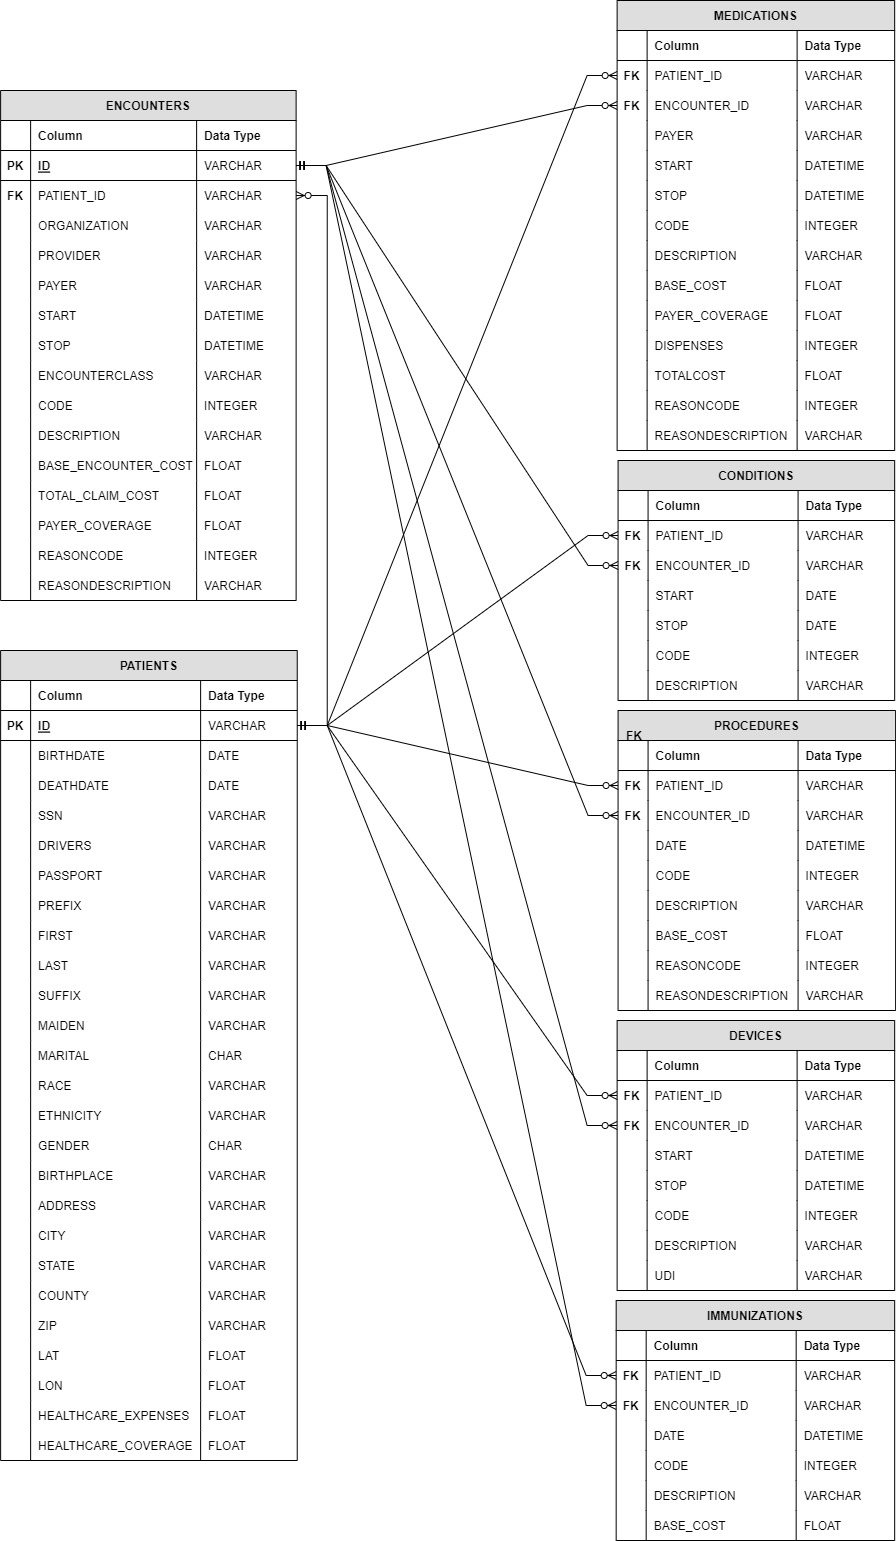

# Funktionen für Import der Quelldaten in zuvor erzeugte Tabellen

Nachdem nun die Tabellen erzeugt wurde, werden sie mit den Quelldaten beladen. Hierfür sind die folgenden Funktionen erforderlich:

In [19]:
db_file = DB_FILE_PATH

In [20]:
# Verbindung zu Datenbank setzen
def connect_to_db(db_file):
    """
    Connect to an SQlite database, if db file does not exist it will be created
    :param db_file: absolute or relative path of db file
    :return: sqlite3 connection
    """
    sqlite3_conn = None

    try:
        sqlite3_conn = sqlite3.connect(db_file)
        return sqlite3_conn

    except Error as err:
        print(err)

        if sqlite3_conn is not None:
            sqlite3_conn.close()

# CSV Daten einlesen und diese in entsprechende Tabelle in Datenbank einfügen
def insert_values_to_table(cursor, table_name, csv_file_path):

    """
    Open a csv file, store its content in a list excluding header and insert the data from the list to db table
    :param table_name: table name in the database to insert the data into
    :param csv_file_path: path of the csv file to process
    :return: None
    """

    # Einlesen
    values_to_insert = open_csv_file(csv_file_path)

    # Einfügen in Tabellen
    if len(values_to_insert) > 0:
        column_names, column_numbers = get_column_names_from_db_table(cursor, table_name)

        values_str = '?,' * column_numbers
        # print("*****", values_str, column_names, column_numbers)
        values_str = values_str[:-1]

        sql_query = 'INSERT OR REPLACE INTO ' + table_name + '(' + column_names + ') VALUES (' + values_str + ')'


        cursor.executemany(sql_query, values_to_insert)
        # conn.commit()

        print('SQL insert process finished')
    else:
        print('Nothing to insert')

        # conn.close()

    # else:
        # print('Connection to database failed')


# CSV-Datei im Reading-Modus öffnen und als csv_file speichern, Liste aus den Daten erstellen.
def open_csv_file(csv_file_path):
    """
    Open and read data from a csv file without headers (skipping the first row)
    :param csv_file_path: path of the csv file to process
    :return: a list with the csv content
    """
    with open(csv_file_path, 'r', encoding='utf-8') as csv_file:
        reader = csv.reader(csv_file)
        next(reader)

        data = list()
        for row in reader:
            data.append(row)

        return data

# Die Spaltennamen aus einer Datenbanktabelle in eine Liste umwandeln und in eine durch Komma getrennte Zeichenkette umwandeln.
# Erstellen eines SQL-Cursors, der auf Datenbank verweist und aufgerufen wird.
def get_column_names_from_db_table(sql_cursor, table_name):
    """
    Scrape the column names from a database table to a list and convert to a comma separated string, count the number
    of columns in a database table
    :param sql_cursor: sqlite cursor
    :param table_name: table name to get the column names from
    :return: a comma separated string with column names, an integer with number of columns
    """

    table_column_names = 'PRAGMA table_info(' + table_name + ');'
    sql_cursor.execute(table_column_names)
    table_column_names = sql_cursor.fetchall()

    column_count = len(table_column_names)

    column_names = list()

    for name in table_column_names:
        column_names.append(name[1])

    return ', '.join(column_names), column_count



In [21]:
# Überprüfen der SQL Tabellen
sql_table.keys()

dict_keys(['conditions', 'devices', 'encounters', 'immunizations', 'medications', 'patients', 'procedures'])

# CSV Dateien in Datenbank überführen

Nach der Formulierung von Definitionen zum Import der Quelldaten soll nund mittels eines Schleifenbefehls das Einlesen der CSV Daten in die Datenbank erfolgen und die respektiven Daten in die zuvor erstellten Tabellen eingebettet werden.
Am Ende "commit" zur Bestätigung der Änderungen, die an Datenbank vorgenommen wurden.

In [22]:
# import csv into db
conn = connect_to_db(DB_FILE_PATH)
if conn is not None:
        cursor = conn.cursor()
        for name in sql_table.keys():
          csv_file = csv_path + name + ".csv"
          print(name, csv_file)
          
          cursor.execute(sql_table[name])

          insert_values_to_table(cursor, name, csv_file)
          conn.commit()
else:
        print('Connection to database failed')


conditions /content/drive/Shareddrives/DMA_2023_D/DMA2023TeamB/Quelldaten/covid19/conditions.csv
SQL insert process finished
devices /content/drive/Shareddrives/DMA_2023_D/DMA2023TeamB/Quelldaten/covid19/devices.csv
SQL insert process finished
encounters /content/drive/Shareddrives/DMA_2023_D/DMA2023TeamB/Quelldaten/covid19/encounters.csv
SQL insert process finished
immunizations /content/drive/Shareddrives/DMA_2023_D/DMA2023TeamB/Quelldaten/covid19/immunizations.csv
SQL insert process finished
medications /content/drive/Shareddrives/DMA_2023_D/DMA2023TeamB/Quelldaten/covid19/medications.csv
SQL insert process finished
patients /content/drive/Shareddrives/DMA_2023_D/DMA2023TeamB/Quelldaten/covid19/patients.csv
SQL insert process finished
procedures /content/drive/Shareddrives/DMA_2023_D/DMA2023TeamB/Quelldaten/covid19/procedures.csv
SQL insert process finished


In [23]:
conn.commit()

# Überprüfen der Dateninsertion in Datenbank

Exemplarisches Überprüfen des korrekten Ladens der Daten in die Datenbank durch Abfrage von Tabellen und einer Tabelle in Gesamtsicht.

In [24]:
# Überprüfen der Tabellen in der Datenbank
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

[('conditions',), ('devices',), ('encounters',), ('immunizations',), ('medications',), ('patients',), ('procedures',)]


In [28]:
## Exemplarisches Überprüfen der Daten in Tabelle "patients" der Datenbank
cursor.execute("SELECT * FROM encounters;")
rows = cursor.fetchall()
for row in rows:
  print(row)

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
('cea1f27b-e27f-b696-c3aa-71596fda03d3', '2010-07-04T06:37:59Z', '2010-07-04T06:52:59Z', 'b56193a1-5bfb-bb37-0886-9a02d10edd41', '31e9cf39-3250-341e-a7d5-9712a4264077', 'f8d1af59-a330-3be0-b209-92216f06794c', '5059a55e-5d6e-34d1-b6cb-d83d16e57bcf', 'wellness', 162673000, 'General examination of patient (procedure)', 129.16, 129.16, 129.16, '', '')
('5cfa23a0-d721-d85e-f0b1-9f6f9965e22c', '2011-07-10T06:37:59Z', '2011-07-10T06:52:59Z', 'b56193a1-5bfb-bb37-0886-9a02d10edd41', '31e9cf39-3250-341e-a7d5-9712a4264077', 'f8d1af59-a330-3be0-b209-92216f06794c', '5059a55e-5d6e-34d1-b6cb-d83d16e57bcf', 'wellness', 162673000, 'General examination of patient (procedure)', 129.16, 129.16, 129.16, '', '')
('4312b8bf-3fa6-7fed-5337-cf19cb92450c', '2012-07-15T06:37:59Z', '2012-07-15T06:52:59Z', 'b56193a1-5bfb-bb37-0886-9a02d10edd41', '31e9cf39-3250-341e-a7d5-9712a4264077', 'f8d1af59-a330-3be0-b209-92216f06794c', '5059a55e-5d6e-34d1-b6cb

In [ ]:
## Exemplarisches Überprüfen der Daten in Tabelle "patients" der Datenbank
cursor.execute("SELECT * FROM patients;")
rows = cursor.fetchall()
for row in rows:
  print(row)

('2f114e21-8b95-e9eb-2e9e-4b950b059cfa', '2002-05-05', '', '999-23-8106', 'S99926648', '', 'Ms.', 'Terisa250', 'Kreiger457', '', '', '', 'white', 'nonhispanic', 'F', 'Oxford  Massachusetts  US', '325 Robel Route Apt 85', 'Swampscott', 'Massachusetts', 'Essex County', 1907, 42.4727363030401, -70.87652826750256, 471180, 2784.81)
('2812f4fc-6aba-0033-728b-7e569bb8adcc', '1942-05-24', '', '999-24-5281', 'S99910925', 'X76697172X', 'Mr.', 'Romeo514', 'Morar593', '', '', 'M', 'white', 'nonhispanic', 'M', 'Springfield  Massachusetts  US', '496 Klein Wynd Unit 85', 'Charlton', 'Massachusetts', 'Worcester County', '', 42.13146482202136, -71.97033335268013, 1606235, 5375.37)
('9b1a203a-6368-49a5-0c79-45c32729bc17', '2013-06-15', '', '999-75-9525', '', '', '', 'Jamaal34', 'Hessel84', '', '', '', 'white', 'nonhispanic', 'M', 'Framingham  Massachusetts  US', '184 Corkery Byway', 'Methuen', 'Massachusetts', 'Essex County', '', 42.730659566644164, -71.15944177306567, 172970, 2074.0499999999997)
('52a2

In [29]:
conn.close()
